In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
import numpy as np

# Define the Keras model builder function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    
    model.add(layers.Dense(10, activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Load and preprocess the dataset
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# Instantiate the tuner and perform hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuning_dir',
    project_name='mnist_hyperparam_tuning')

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.9607777794202169

Best val_accuracy So Far: 0.9760555624961853
Total elapsed time: 00h 04m 03s


In [2]:
import pandas as pd

def retrieve_results_keras_tuner(tuner, metric, num_best_trials=1):
    trials = tuner.oracle.get_best_trials(num_best_trials)
    columns = list(trials[0].hyperparameters.values.keys())
    columns.append(metric)
    results = pd.DataFrame(columns=columns)
    for trial in trials:
        trial_results = list(trial.hyperparameters.values.values())
        trial_results.append(trial.metrics.get_best_value(metric))
        results = pd.concat([results, pd.DataFrame([trial_results], columns=columns)], ignore_index=True)
    return results

In [3]:
results = retrieve_results_keras_tuner(tuner, "val_accuracy", 5)

/tmp/ipykernel_22899/561427707.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([trial_results], columns=columns)], ignore_index=True)


In [4]:
import sys
sys.path.append("../")

In [5]:
import os
print(os.environ.get("PYTHONPATH"))

None


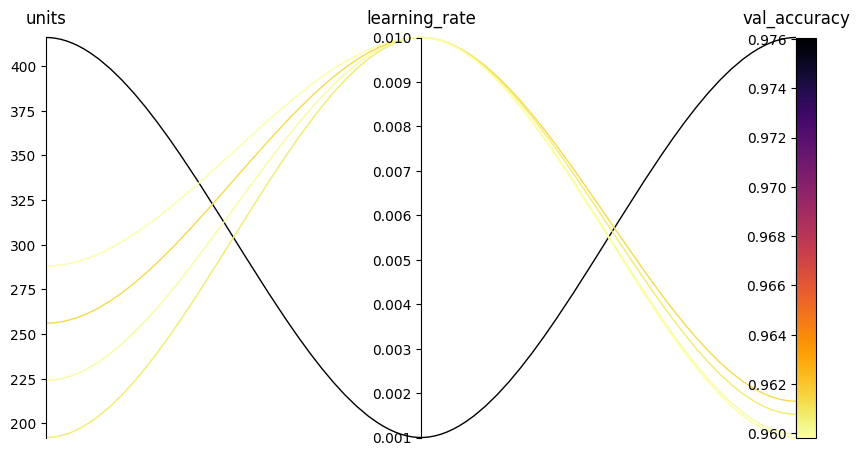

In [6]:
from src.helper_functions import plot

fig = plot.plot_parallel_coordinates(results, labels=results.columns);

## GridSearchCV example

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate some sample data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20],        # Maximum depth of the trees
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required at each leaf node
}

# Initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [8]:
import pandas as pd
def retrieve_results_sklearn(tuner, metric):
    hyperparameters = tuner.cv_results_["params"]
    scores = tuner.cv_results_[metric]
    results = pd.DataFrame(hyperparameters)
    results[metric] = scores
    return results

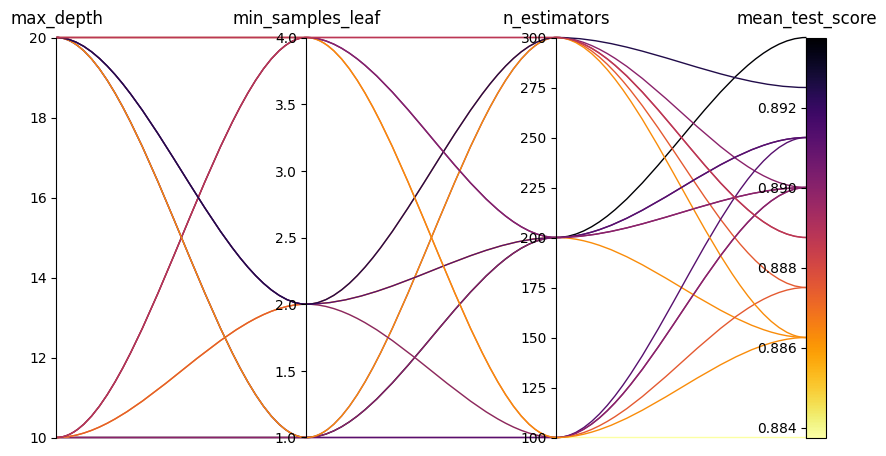

In [9]:
import sys
sys.path.append("../")

from src.helper_functions import plot
results = retrieve_results_sklearn(grid_search, "mean_test_score")
fig = plot.plot_parallel_coordinates(results, labels=results.columns);

## RandomizedSearchCV example

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution to sample from
param_dist = {
    'n_estimators': randint(100, 1000),           # Number of trees in the forest
    'max_depth': randint(1, 100, 20),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),          # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20)            # Minimum number of samples required at each leaf node
}

# Initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fde0f481de0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fde0db561d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fde0db54ca0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fde0f4d2e90>},
                   random_state=42, scoring='accuracy')

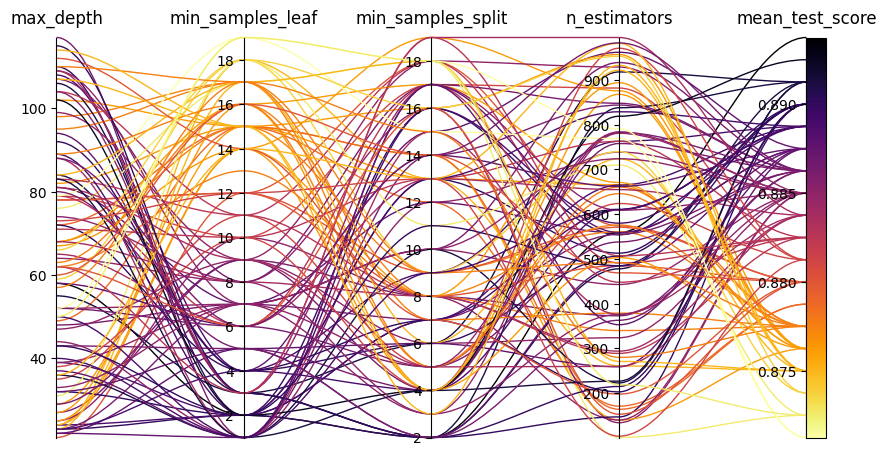

In [11]:
results = retrieve_results_sklearn(random_search, "mean_test_score")
fig = plot.plot_parallel_coordinates(results, labels=results.columns);

## Optuna example

In [12]:
import xgboost as xgb 

from sklearn.datasets import load_diabetes

# Load the diabetes dataset
diabetes_data = load_diabetes()

# Extract features and target variable
X = diabetes_data.data
y = diabetes_data.target
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dm_train = xgb.DMatrix(X_train, label=y_train)

In [13]:
def objective(trial):
    # define the hyperparameters to be tuned
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "device": "cuda:0",
        "subsample": 0.8,
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "eta": trial.suggest_float("eta", 0.05, 0.5),
        "gamma": trial.suggest_float("gamma", 0.001, 0.01),
        "lambda": trial.suggest_float("lambda", 0.1, 5),
        "alpha": trial.suggest_float("alpha", 0.001, 0.01),
    }
    
    # set up the cross-validation procedure
    xgb_cv = xgb.cv(params, dm_train, num_boost_round=2000, nfold=5, early_stopping_rounds=5, verbose_eval=False, as_pandas=True)

    mse = xgb_cv["test-rmse-mean"].min()
    std = xgb_cv.loc[xgb_cv["test-rmse-mean"].idxmin(), "test-rmse-std"]
    
    # log how many estimators were used (after early stopping) and standard deviation
    trial.set_user_attr("n_estimators", len(xgb_cv))
    trial.set_user_attr("std", std)
    print(f"Trial #{trial.number}. Root Mean Squared Error = {mse:.4f} +/- {std:.4f}")
    return mse

In [14]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# set up the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# print the best hyperparameters and mape
best_hyperparameters = study.best_params
best_mse = study.best_value
print(f"Best MAPE: {best_mse:.4f}")

/home/tommaso/miniconda3/envs/ds_fin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trial #0. Root Mean Squared Error = 61.5233 +/- 3.8129
Trial #1. Root Mean Squared Error = 63.0711 +/- 4.2250
Trial #2. Root Mean Squared Error = 62.2408 +/- 3.0463
Trial #3. Root Mean Squared Error = 63.1194 +/- 3.2218
Trial #4. Root Mean Squared Error = 63.6077 +/- 4.5473
Trial #5. Root Mean Squared Error = 65.4291 +/- 4.2551
Trial #6. Root Mean Squared Error = 62.8148 +/- 5.1487
Trial #7. Root Mean Squared Error = 65.7601 +/- 3.6798
Trial #8. Root Mean Squared Error = 59.9481 +/- 3.1152
Trial #9. Root Mean Squared Error = 63.4971 +/- 2.3504
Trial #10. Root Mean Squared Error = 57.4490 +/- 3.5841
Trial #11. Root Mean Squared Error = 57.6562 +/- 3.6516
Trial #12. Root Mean Squared Error = 57.9570 +/- 3.6678
Trial #13. Root Mean Squared Error = 57.4573 +/- 3.2124
Trial #14. Root Mean Squared Error = 59.6682 +/- 2.9489
Trial #15. Root Mean Squared Error = 58.6076 +/- 3.0317
Trial #16. Root Mean Squared Error = 61.8296 +/- 3.9259
Trial #17. Root Mean Squared Error = 58.0695 +/- 4.2078
Tr

In [15]:
def retrieve_results_optuna(study, metric, custom_columns=[]):
    results_df = study.trials_dataframe()
    custom_columns = ["user_attrs_" + n for n in custom_columns]
    columns_to_drop = ["number", "datetime_start", "datetime_complete", "duration", "state"] + custom_columns
    results = results_df.drop(columns_to_drop, axis=1)
    swap_columns = list(results.columns)
    swap_columns[0], swap_columns[-1] = swap_columns[-1], swap_columns[0]
    results = results[swap_columns]
    results.columns = [n.split("params_")[-1] for n in results.columns]
    results.columns = list(results.columns[:-1]) + [metric]
    return results    

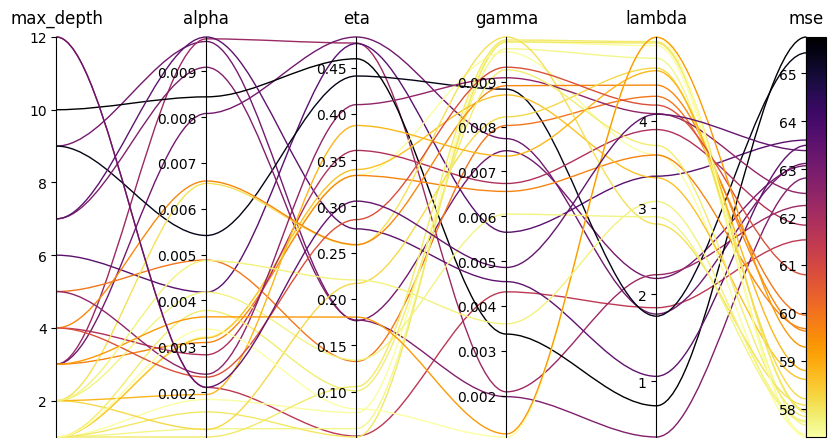

In [16]:
results = retrieve_results_optuna(study, "mse", custom_columns=["n_estimators", "std"])
fig = plot.plot_parallel_coordinates(results, labels=results.columns);